Disentangled representations with $\beta$-VAE and forced learning of some traits for Radio Galaxies

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec

In [2]:
from rg_dataset import LRG, UNLRG, UNLRG_C

In [3]:
lrg_data_set = LRG(use_kittler=True, blur=True)
unlrg_data_set = UNLRG_C(use_kittler=True)

LRG:	1442/1442
LRG:	14245/14245


In [4]:
data_loader_lrg   = data.DataLoader(lrg_data_set, batch_size=64, shuffle=False)
data_loader_unlrg = data.DataLoader(unlrg_data_set, batch_size=64, shuffle=False)

sample = iter(data_loader_lrg).next()

In [5]:
#Simple Variational Auto Encoder
class VAE(nn.Module):
    def __init__(self, lt_dim=4):
        super(VAE, self).__init__()
        self.k = [1, 16, 32, 64, 128, 256]
#         self.k = [1, 64, 128, 256, 512, 512]
        encoder_layers = []
        decoder_layers = []
        
        for i in range(len(self.k) - 1):
            layer = nn.Conv2d(self.k[i], self.k[i+1], 3, 2, 1, 1)
            encoder_layers.append(layer)
            encoder_layers.append(nn.ReLU())
        
        for i in range(len(self.k) - 1, 0, -1):
            layer = nn.ConvTranspose2d(self.k[i], self.k[i-1], 3, 2, 1, 1)
            decoder_layers.append(layer)
            decoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Linear(self.k[-1]*2*2, lt_dim)
        self.fc_ep = nn.Linear(self.k[-1]*2*2, lt_dim)
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
    def encode(self, x):
        encoded = self.encoder(x).view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, x):
        x = F.relu(self.fc_dc(x)).view(-1, self.k[-1], 2, 2)
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

In [6]:
class B_VAE_Loss:
    def __init__(self, gamma, max_capacity, epochs):
        self.gamma = gamma
#         self.recon_ls = nn.MSELoss(reduction='sum')
        self.recon_ls = nn.BCELoss(reduction='sum')
        #self.recon_ls = nn.BCEWithLogitsLoss(reduction='sum')
        self.capacity = 0
        self.delta = max_capacity / float(epochs)
        self.max_capacity = max_capacity
    def update(self):
        self.capacity = min(self.max_capacity, self.capacity + self.delta)
        return self.capacity
    def __call__(self, res, img):
        batch_sz = len(img)
        x, mu, logvar = res
        recon = self.recon_ls(x, img).div(batch_sz) #res -> x, mu, var
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).div(batch_sz)
        return self.capacity, recon, self.gamma * (kld - self.capacity).abs()

In [11]:
def train_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    s = ''
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = Variable(target, requires_grad=False).to(device)
        #Forward Pass
        optimizer.zero_grad()
        output = model(data)
        
        #############################################
        ######### check against known class #########
        #############################################
        #########    Compact vs Extended    #########
        extended = target > 1
        extended = Variable(extended.float().to(device), requires_grad=False)
        pred_ext = torch.sigmoid(output[1][:,0])
        ext_loss = F.binary_cross_entropy(pred_ext, extended, reduction='sum').div(len(pred_ext))
        #########       FRI vs FRII         #########
        o = torch.sigmoid(output[1][:, 1])[target > 1]
        c = target[target > 1]
        o = o[c < 4]
        c = c[c < 4]
        c = Variable( (c == 3).float().to(device), requires_grad=False)
        fr_loss = F.binary_cross_entropy(o, c, reduction='sum').div(len(c))
        #########   Regular vs Irregular   #########
#         o = torch.sigmoid(output[1][:, 2])[target > 1]
#         c = target[target > 1]
# #         o = o[c < 4]
#         c = c < 4
#         c = Variable( c.float().to(device), requires_grad=False)
#         reg_loss = F.binary_cross_entropy(o, c, reduction='sum').div(len(c))
        # BCE Loss
        c, r_loss , g_loss = beta_vae_loss(output, data)
        loss = r_loss + g_loss + 10 * (ext_loss + fr_loss)# + reg_loss)
        #Backpropagation
        loss.backward()
        optimizer.step()
        s = 'Train Epoch: {:3d} [{:5d}/{:5d} ({:3.0f}%)]   Loss: {:4.4f}   R_Loss: {:4.4f}   Capacity: {:4.2f}'
        s = s.format(epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item(), r_loss.item(), c)
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [18]:
def test_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        with torch.no_grad():
            data = data.to(device)
            #Forward Pass
            output = model(data)

            # BCE Loss
            c, r_loss , g_loss = beta_vae_loss(output, data)
            loss = r_loss + g_loss
    return loss

In [19]:
device = 'cuda'
lt_dim = 2
vae = VAE(lt_dim=lt_dim).to(device)
optimizer = Adam(vae.parameters(), lr=0.001, weight_decay=1E-5)

In [20]:
epochs = 50
gam = 10
cap = 5
beta_vae_loss = B_VAE_Loss(gamma=gam, max_capacity=cap, epochs=epochs)
for epoch in range(1, epochs+1):
    #LRG, forced params
    start = time.time()
    s = train_step(vae, 'cuda', data_loader_unlrg, optimizer, epoch)
    loss = test_step(vae, 'cuda', data_loader_lrg, optimizer, epoch)
    t = time.time() - start
    sys.stdout.write('{}   Test Loss : {:4.4f}   Time : {:.2f}s\n'.format(s, loss, t))
    beta_vae_loss.update()

Train Epoch:   1 [127948/141300 (100%)]   Loss: 128.4481   R_Loss: 111.1209   Capacity: 0.0000   Test Loss : 267.3468   Time : 84.79s
Train Epoch:   2 [127948/141300 (100%)]   Loss: 122.1912   R_Loss: 103.6585   Capacity: 0.0500   Test Loss : 261.2873   Time : 84.85s
Train Epoch:   3 [127948/141300 (100%)]   Loss: 121.6635   R_Loss: 102.8652   Capacity: 0.1000   Test Loss : 260.3790   Time : 84.99s
Train Epoch:   4 [127948/141300 (100%)]   Loss: 123.5818   R_Loss: 105.1773   Capacity: 0.1500   Test Loss : 264.1920   Time : 84.82s
Train Epoch:   5 [127948/141300 (100%)]   Loss: 125.7954   R_Loss: 107.4506   Capacity: 0.2000   Test Loss : 262.7502   Time : 84.93s
Train Epoch:   6 [127948/141300 (100%)]   Loss: 118.6657   R_Loss: 100.7979   Capacity: 0.2500   Test Loss : 261.3232   Time : 84.79s
Train Epoch:   7 [127948/141300 (100%)]   Loss: 119.3393   R_Loss: 102.0451   Capacity: 0.3000   Test Loss : 261.4091   Time : 84.79s
Train Epoch:   8 [127948/141300 (100%)]   Loss: 116.5512   R_L

Train Epoch:  62 [127948/141300 (100%)]   Loss: 96.3212   R_Loss: 87.6242   Capacity: 3.0500   Test Loss : 245.9124   Time : 85.00s
Train Epoch:  63 [127948/141300 (100%)]   Loss: 99.9726   R_Loss: 90.6075   Capacity: 3.1000   Test Loss : 247.5251   Time : 85.52s
Train Epoch:  64 [127948/141300 (100%)]   Loss: 98.5603   R_Loss: 89.5250   Capacity: 3.1500   Test Loss : 239.7470   Time : 85.10s
Train Epoch:  65 [127948/141300 (100%)]   Loss: 100.5030   R_Loss: 90.7847   Capacity: 3.2000   Test Loss : 245.1954   Time : 85.11s
Train Epoch:  66 [127948/141300 (100%)]   Loss: 97.7459   R_Loss: 89.3123   Capacity: 3.2500   Test Loss : 243.2665   Time : 84.72s
Train Epoch:  67 [127948/141300 (100%)]   Loss: 100.0235   R_Loss: 89.4436   Capacity: 3.3000   Test Loss : 243.7463   Time : 84.83s
Train Epoch:  68 [127948/141300 (100%)]   Loss: 99.4093   R_Loss: 89.3884   Capacity: 3.3500   Test Loss : 247.2021   Time : 85.06s
Train Epoch:  69 [127948/141300 (100%)]   Loss: 96.4901   R_Loss: 86.4871 

KeyboardInterrupt: 

In [21]:
torch.save(vae, 'b_vae_norot_unlrg_g{}_ld{}_epochs{}_cap{}'.format(gam, lt_dim, epochs, cap))

(-0.5, 63.5, 63.5, -0.5)

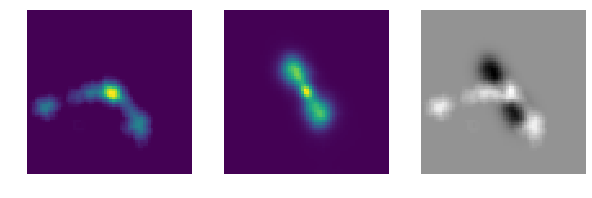

In [22]:
a = 1#6
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0])
ax[1].imshow(d.cpu()[0][0])
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

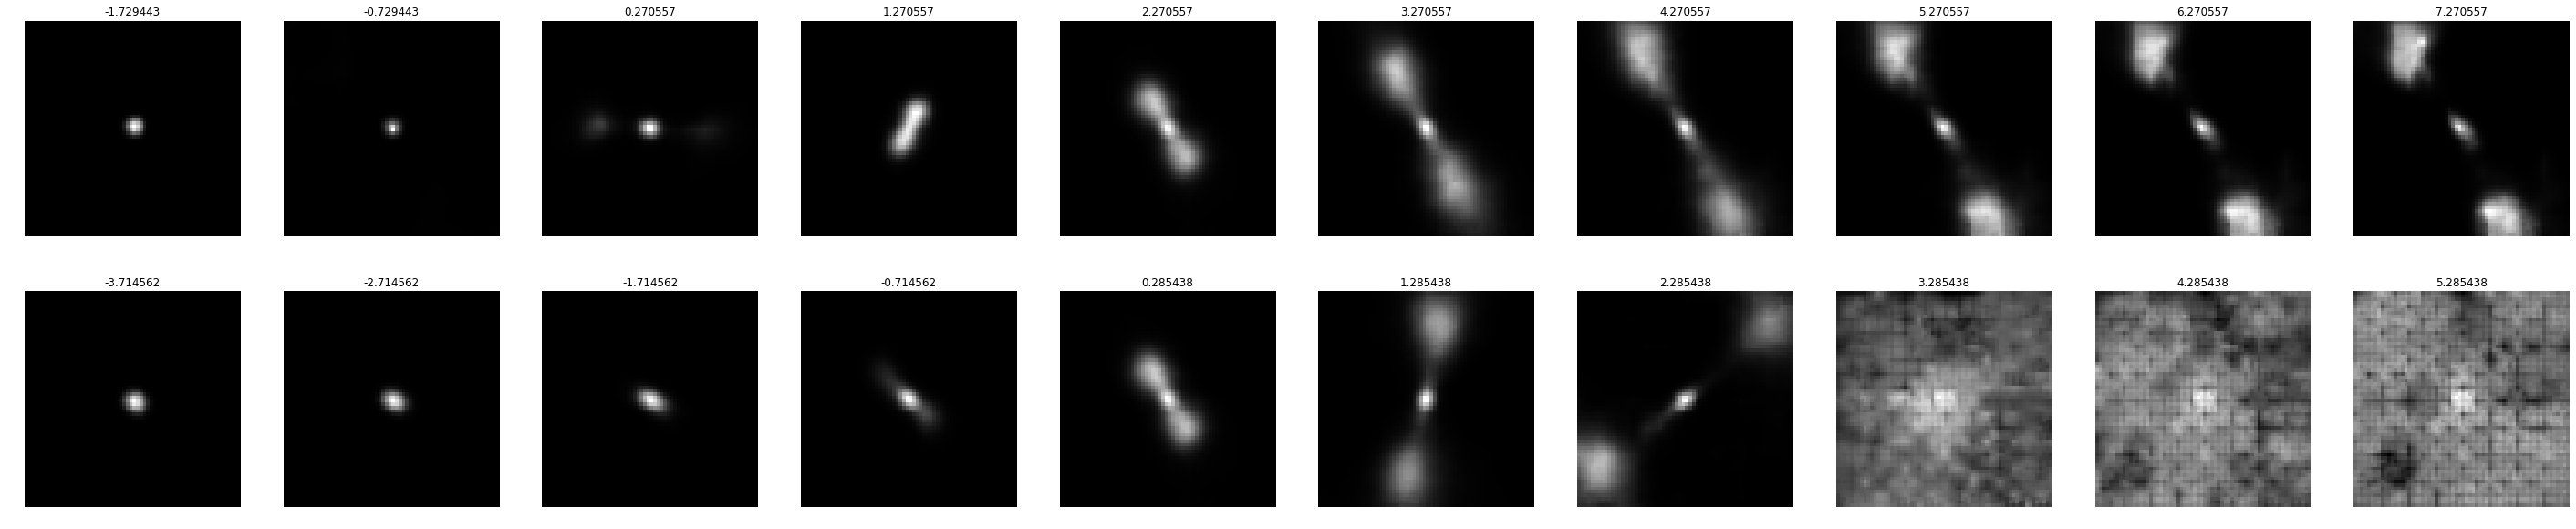

In [23]:
r = 10
nimg = r * lt_dim
k = 1
m = 1
f, ax = plt.subplots(int(nimg/r), r, figsize=(r * 5, nimg * 5 / r))
for i in range(int(nimg/r)):
    for j in range(r):
        with torch.no_grad():
            e = vae.encode(s.to(device))[0]
            v = e[0][i]
            nv = -4*k + v + k*j
            e[0][i] = nv
            d = vae.decode(e).cpu()[0][0]
        ax[i][j].imshow(d, cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title('{:2f}'.format(nv))

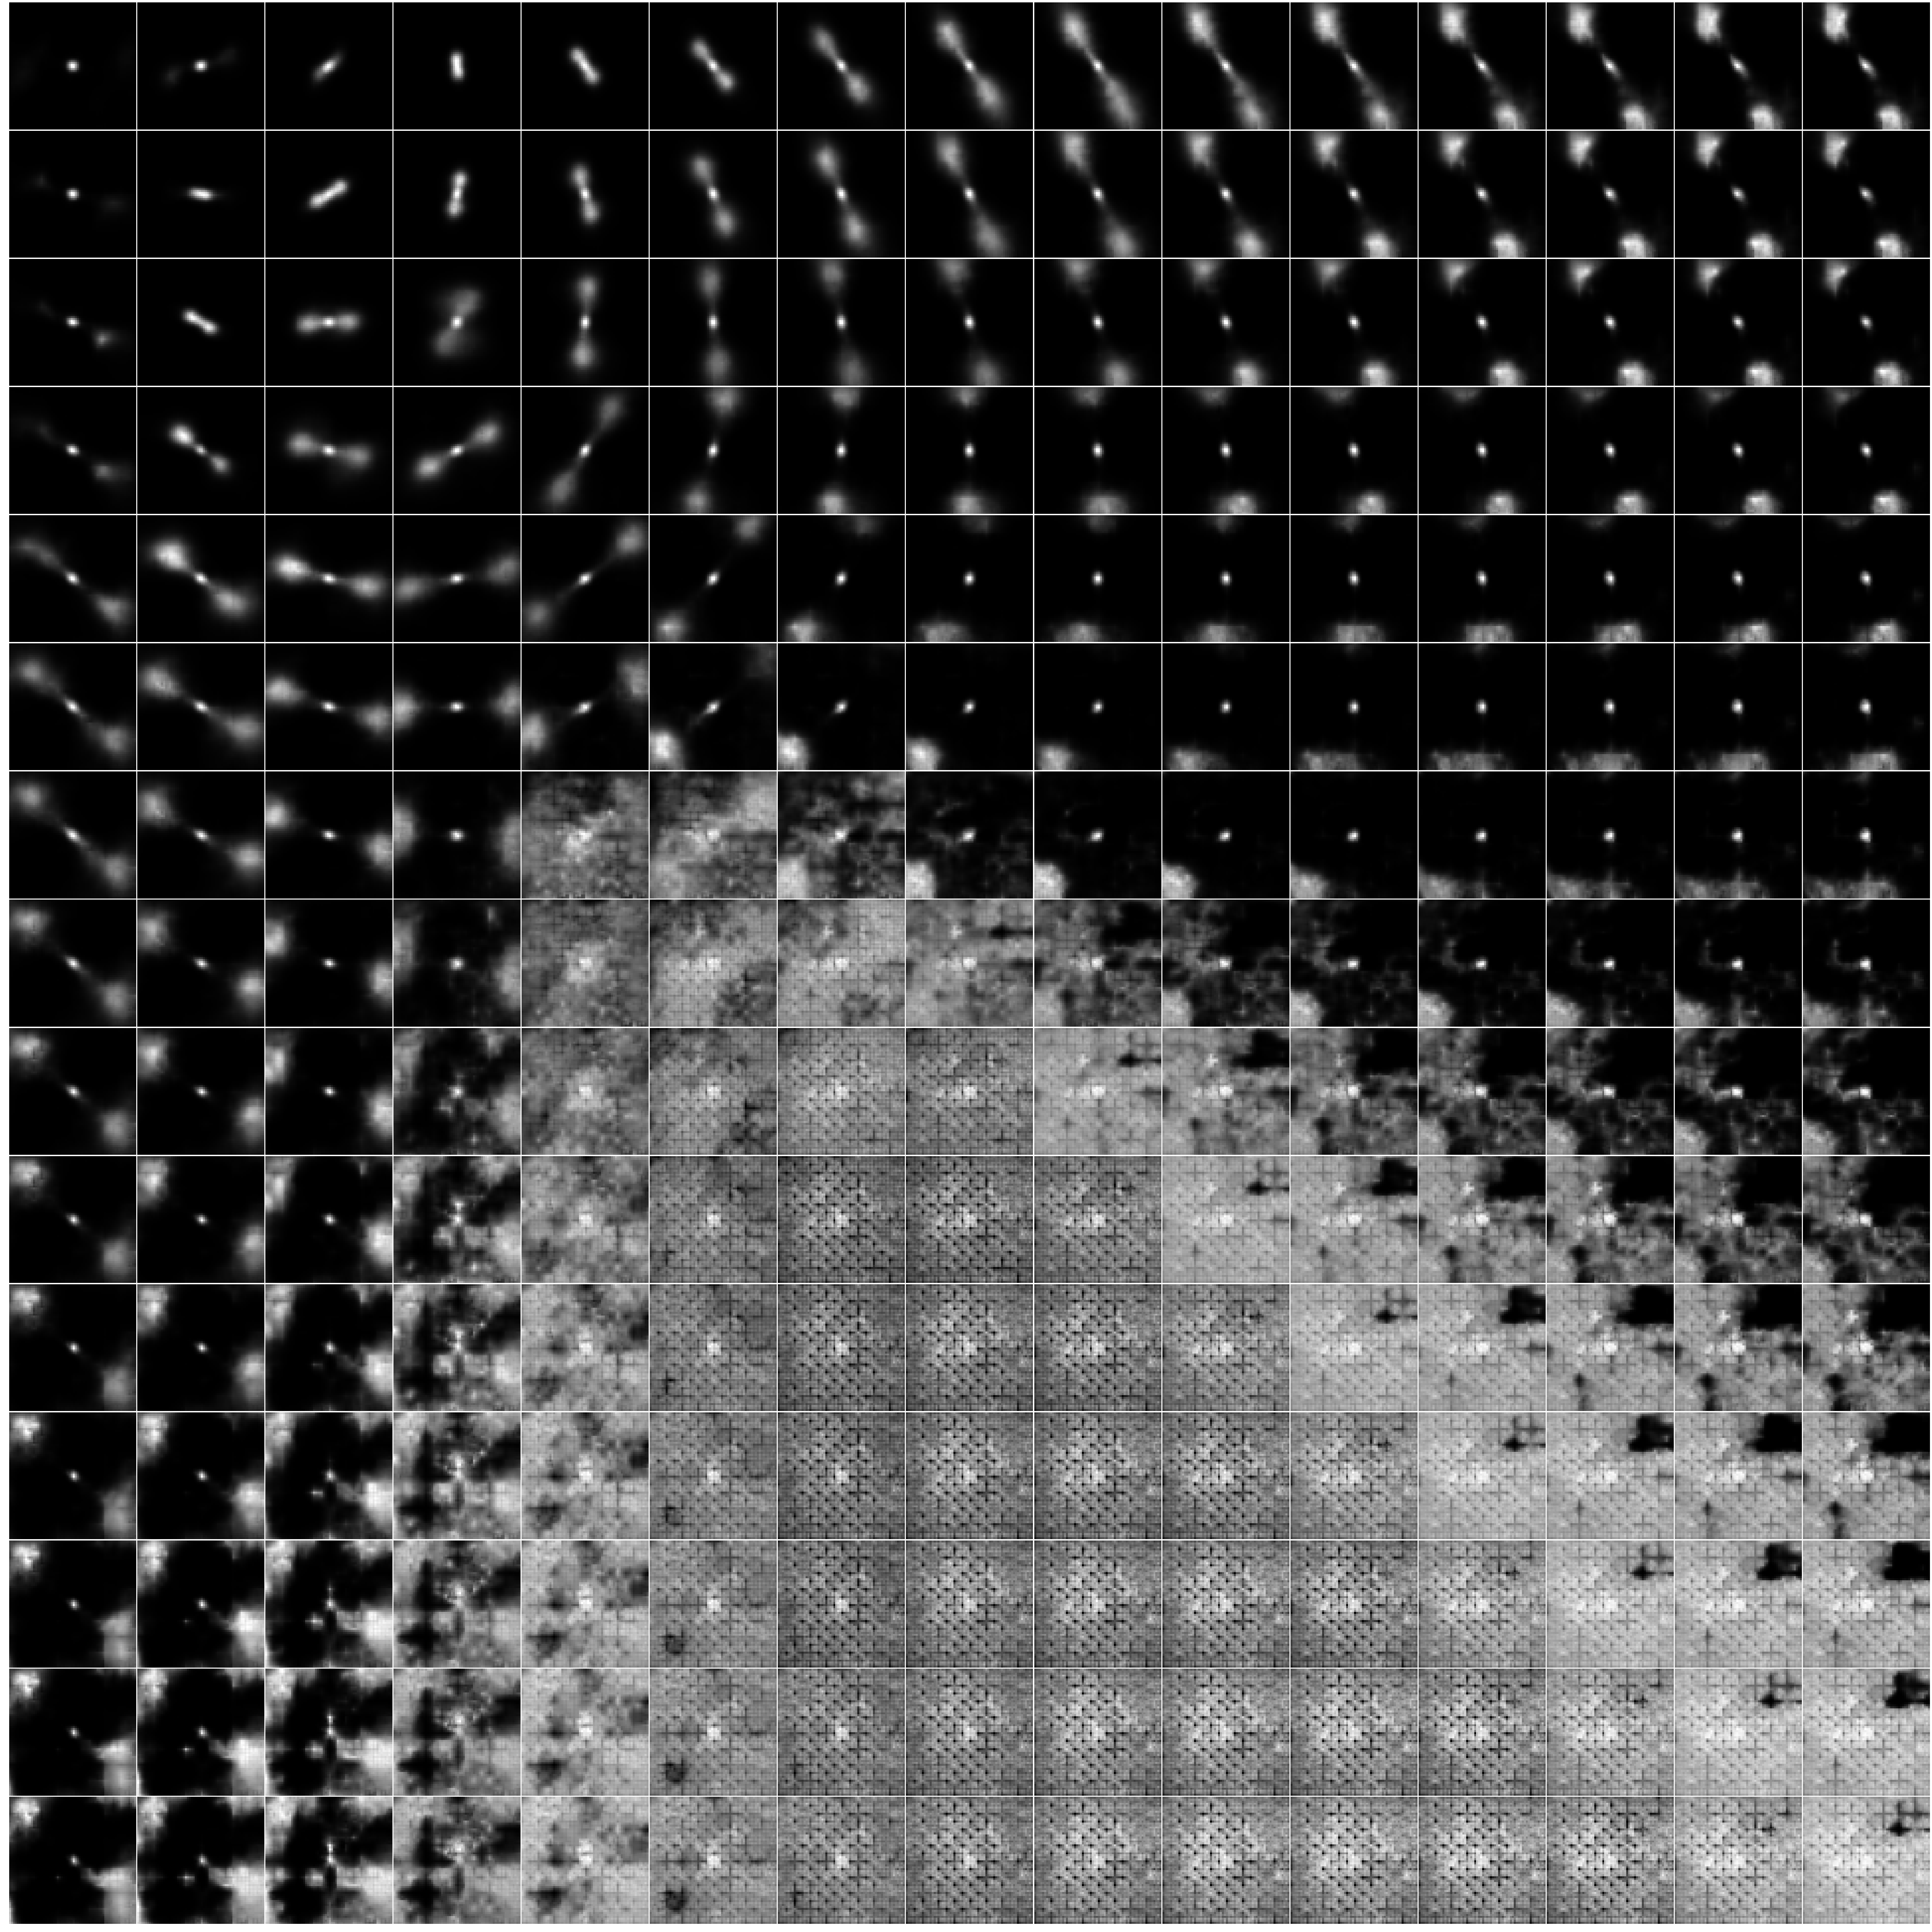

In [25]:
r = 15
nimg = r * 15

plt.figure(figsize=(101.3, 104))
gs1 = gridspec.GridSpec(15, r)
gs1.update(wspace=0.01, hspace=0.01)

for i in range(15):
    for j in range(r):
        ax1 = plt.subplot(gs1[i*r+j])
        plt.axis('off')
        with torch.no_grad():
            e = torch.Tensor([-j/2 + j, -i/2  + i]).cuda()
            d = vae.decode(e).cpu()[0][0]
        ax1.imshow(d, cmap='gray')
        ax1.set_aspect('equal')